## Towards Data Science - Transfer Learning Tutorial

This is from https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
is the overview of the techniques, but at the end is a practical guide in the real world using Keras to graft a dog and cat discriminator on top of a pretrained model.

# A note on using this with docker
If you are using a docker container make sure there is enogh emmory. With just 2GB of memory, the file loading with thrash. Suggest 4-6GB. Set this in Docker for Desktop on the Mac in the Preferences/Advanced

# Notes on gathering images from Google Images
There are a bunch of Chrome download helpers that will download a complete images. The recommended one is called Fatkun Batch downloader. YOu have to remember to ask it to rename the images. And make sure "Ask where to download is" *not* set in Preferences

There is another called ImageAssistant Batch Loader. both of these work pretty well with the ImageAssistant also harmonizing all the image names

# Getting data from kaggle

Where we will apply transfer learning to dogs vs cats on top of existing deep neural networks. First we have to get the actual data from kaggle at https://www.kaggle.com/c/dogs-vs-cats/data

You can either click on the download link or use a python utility called kaggle to get it from https://github.com/Kaggle/kaggle-api

Security-wise, you should goto your account `https://kaggle.com/<username>/account` and select `Create an API Token` whih will generation `kaggle.json` which should live in `~/.kaggle/kaggle.json`. If you are using @Rich's scheme, this means you should copy that to the `/Volumes/rich.vc/.ssh` and this will get linked in the ~/.ssh directory. And then you want a symlink from there `ln -s ~/.ssh/kaggle.json ~/.kaggle` and this will be secure

In [ ]:
comment out this line if you really want to run this
should only do once
# only needs to be installed once
!pip install kaggle numpy
# make sure to go to https://www.kaggle.com/c/dogs-vs-cats/rules
# And accept the rules of the competition
# make sure to that git lfs is operating if you do this in a git repo
# Run the line below once. Warning this is a 1GB download!
kaggle competitions download -c dogs-vs-cats

## Note on loading libraries and dependencies
First, let's make sure list in the Jupyter Notebook, the actual configuration we are running using pip

In [2]:
!pip freeze > requirements.txt
!cat requirements.txt

absl-py==0.7.1
alembic==1.0.8
asn1crypto==0.24.0
astor==0.7.1
async-generator==1.10
attrs==19.1.0
backcall==0.1.0
beautifulsoup4==4.7.1
bleach==3.1.0
blinker==1.4
bokeh==1.0.4
certifi==2019.6.16
certipy==0.1.3
cffi==1.12.3
chardet==3.0.4
Click==7.0
cloudpickle==0.8.1
conda==4.6.14
cryptography==2.6.1
cycler==0.10.0
Cython==0.29.7
cytoolz==0.9.0.1
dask==1.1.5
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
distributed==1.28.0
entrypoints==0.3
fastcache==1.1.0
gast==0.2.2
gmpy2==2.0.8
grpcio==1.16.1
h5py==2.9.0
heapdict==1.0.0
idna==2.8
imageio==2.5.0
ipykernel==5.1.0
ipython==7.5.0
ipython-genutils==0.2.0
ipywidgets==7.4.2
jedi==0.13.3
Jinja2==2.10.1
jsonschema==3.0.1
jupyter-client==5.2.4
jupyter-core==4.4.0
jupyterhub==1.0.0
jupyterlab==0.35.5
jupyterlab-server==0.2.0
kaggle==1.5.4
Keras==2.2.4
Keras-Applications==1.0.7
Keras-Preprocessing==1.0.9
kiwisolver==1.1.0
llvmlite==0.27.1
locket==0.2.0
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.1.1
matplotlib==3.0.3
mistune==0.8.4
mock==3.0.5


This will give you two files `train.zip` and `test1.zip` with 500MB and 250MB worth of JPEGs. So let's process them. As an aside, you definitely to `git track "*.jpg"` before sticking this into your repo.

In [2]:
import glob
import numpy as np
import os
import shutil

# keep things deterministic and set a fixed seed
np.random.seed(42)

Now use glob to expand the files names in the train directory. then use an expression that sticks all the files names in cat_files and dog_files

In [3]:
files = glob.glob('train/*')
print('total files', len(files), files[0])

total files 25000 train/dog.8011.jpg


In [4]:
cat_files = [f for f in files if 'cat' in f]
dog_files = [f for f in files if 'dog' in f]
print(type(cat_files), len(cat_files), 'cats, ', len(dog_files), 'dogs')

<class 'list'> 12500 cats,  12500 dogs


Now we use np.random.choice which randomly selects `size` files and put them into the training set. Then the very clever `set` function which removes those files. Then do the same for validation and test sets

In [5]:
def pickout(source, size):
    # choose elements without ever picking the same one twice
    chosen = np.random.choice(source, size=size, replace=False)
    remainder = list(set(source) - set(chosen))
    return chosen, remainder

# do it the rote way without a function
cat_train = np.random.choice(cat_files, size=1500, replace=False)
# convert two lists to sets, take the reminader and reconvert to list
# https://www.geeksforgeeks.org/python-set-operations-union-intersection-difference-symmetric-difference/
# minus means difference
cat_less_train = list(set(cat_files) - set(cat_train))
print('cat_train', len(cat_train), 'cat_less_train', len(cat_less_train))

cat_val, cat_less_train_and_val = pickout(cat_less_train, 500)
cat_test, _ = pickout(cat_less_train_and_val, 500)

print('cat_train', len(cat_train), 'cat_val', len(cat_val), 'cat_test', len(cat_test))

# now do the dogs

dog_train, remainder = pickout(dog_files, 1500)
dog_val, remainder = pickout(remainder, 500)
dog_test, _ = pickout(remainder, 500)

assert(set(dog_train).intersection(set(dog_val)) == set())
assert(set(dog_train).intersection(set(dog_test)) == set())

print('dog_train', len(dog_train), 'dog_val', len(dog_val), 'dog_test', len(dog_test))
# https://stackoverflow.com/questions/6130374/empty-set-literal/6130391 
# uses the method intersection and there is no literal for null
# https://www.digitalocean.com/community/tutorials/how-to-use-args-and-kwargs-in-python-3
# for variable arguments
# https://stackoverflow.com/questions/22432814/check-if-a-collection-of-sets-is-pairwise-disjoint
# this wrks by rebuilding element by element and ensuring there
# are no duplicates which is the definition of all disjoing
# note that this is not vectorized
def all_disjoint(*args):
    union = set()
    for arg in args:
        for item in arg:
            if item in union:
                # we found a duplicate so these are not all disjoing
                return False
            union.add(item)
    return True

assert(all_disjoint(dog_train, dog_val, dog_test, cat_train, cat_val, cat_test))
# https://stackoverflow.com/questions/22432814/check-if-a-collection-of-sets-is-pairwise-disjoint
# it's faster just to do a count and this is vectorized
def all_disjoint_by_count(*args):
    union_of_all_sets = set()
    total_elements_of_all_sets = 0
    for arg in args:
        arg_as_set = set(arg)
        union_of_all_sets = union_of_all_sets.union(arg_as_set)
        total_elements_of_all_sets += len(arg_as_set)
    return total_elements_of_all_sets == len(union_of_all_sets)

assert(all_disjoint_by_count(dog_train, dog_val, dog_test, cat_train, cat_val, cat_test))

cat_train 1500 cat_less_train 11000
cat_train 1500 cat_val 500 cat_test 500
dog_train 1500 dog_val 500 dog_test 500


Now for convenience dump them all to disk

In [7]:
# copy_to_dir(target_dir, list of files...)
# https://www.geeksforgeeks.org/args-kwargs-python/

# warning you only need to run this once

comment_out_this_if_you_really_need_for_the_first_time


def copy_to_dir(target_dir, source, *args):
    for arg in args:
        source = np.concatenate([source, arg])
    print('target_dir', target_dir, 'source', len(source))
    # I have no idea why this works, but it is in 
    os.mkdir(target_dir) if not os.path.isdir(target_dir) else None
    for file in source:
        shutil.copy(file, target_dir)
    

# let's do some directory munging
train_dir = 'train_data'
val_dir = 'val_data'
test_dir = 'test_data'

# gether up all the files
train_files = np.concatenate([cat_train, dog_train])
print(type(train_files), train_files.shape)
val_files = np.concatenate([cat_val, dog_val])

# instead of that yack shaving, make a function
copy_to_dir('train_data', cat_train, dog_train)
copy_to_dir('val_data', cat_val, dog_val)
copy_to_dir('test_data', cat_test, dog_test)

NameError: name 'comment_out_this_if_you_really_need_for_the_first_time' is not defined

## Preparing Datasets
Now the real work begin eparing the data sets. of pr

In [6]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

%matplotlib inline

# Again we avoid duplication with a function
# the default image size is 150x150 pixels
# you can set the directory delimiter
# And the file name delimiter
def files_to_images_and_labels(source, img_dim=(150,150), dir_delimiter='/', file_delimiter='.'):
    # assume a directory and wildcard everything there to get files
    filenames = glob.glob(source + '/*')
    print('source', source, 'filenames', len(filenames))
    # use a list comprehension across all the files names
    
    images = [img_to_array(load_img(img, target_size=img_dim)) for img in filenames]
    # in the tutorial, this is a numpy array, but as of June 2019
    # this is just a plain list, so convert it
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.asarray.html
    images = np.asarray(images)
    
    print('got images', len(images), type(images))
    # now parse the lables, this is encoded in the filename like this
    # /dir/../dir/label.number.ext
    # so for instance the file name will be fully qualified
    # so get rid of the slashes and the stuff after the dot which
    # is the file type and number
    # split breaks up the each file name by the delimiter.
    # we want the very last one, by convention this is -1 the first on
    # from the right
    # then take this basename and pick the first one before the dot
    # and strip out any white space
    # use a list comprehension, which takes a list filenames and then 
    # processes each one and then puts it back into another list
    labels = [fn.split(dir_delimiter)[-1].split(file_delimiter)[0].strip() for fn in filenames]
    print('got labels', len(labels), type(labels))
    return images, labels

print('train_data')
train_imgs, train_labels = files_to_images_and_labels('train_data')
print('starting validation set')
val_imgs, val_labels = files_to_images_and_labels('val_data')
print('Train shape', train_imgs.shape, 'Train labels', len(train_labels))
                

Using TensorFlow backend.


train_data
source train_data filenames 3000
got images 3000 <class 'numpy.ndarray'>
got labels 3000 <class 'list'>
starting validation set
source val_data filenames 1000
got images 1000 <class 'numpy.ndarray'>
got labels 1000 <class 'list'>
Train shape (3000, 150, 150, 3) Train labels 3000


# Scaling and preparing the images
Nwo we have 150 height x 150 width x 3 channels of RGB. So to get a better gradient scale the color channels from 0-255 to 0.0 to 1.0

(150, 150, 3)


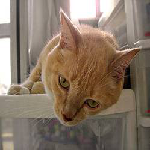

In [7]:
# convert from the integers to floating point
train_imgs_scaled = train_imgs.astype('float32')
val_imgs_scaled = val_imgs.astype('float32')

# now scale from 0 to 1
train_imgs_scaled /= 255
val_imgs_scaled /= 255

# Now debug it and take a look
print(train_imgs[0].shape)
array_to_img(train_imgs[0])


## Now get the labels ready as a one-hot vector
We are using the SKlearn LabelEncoder to make this easy

In [10]:
from sklearn.preprocessing import LabelEncoder

batch_size = 30
num_classes = 2
# Don't need so many epochs to prove the point
# epochs = 30
epochs = 10
input_shape = (150, 150, 3)

# Instantiate an encoder, not this is not a one-hot encoder
le = LabelEncoder()
# Go through all the training labels and learn the
# different tags there
le.fit(train_labels)
# Now turn train and validation sets into one hot vecotrs
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

# now let see what we have
print('raw labels', train_labels[0:4], 'one-hot',  train_labels_enc[0:4])


raw labels ['cat', 'dog', 'cat', 'cat'] one-hot [0 1 0 0]


## Simple CNN from scratch
Ok, let's build a simple CNN that uses the Sequential simple formulation. Ths is first subsample, then maxpool, then subsample and finish with a fully connected layer. 

See https://jovianlin.io/keras-models-sequential-vs-functional/ for the difference, but Deeplearning.ai teaches the functional model because it is more general and you can use for LSTMs, etc.

The major difference is that instead of declaring a Sequential and starting, you instead declare inputs and then pass then as parameters

In [9]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Sequential
from keras import optimizers
from keras.models import Model

# We are using the Sequential model for simplictity
# but we should transform this to the API model at some point
def sequential_model(input_shape):
    model = Sequential()

    # convolve
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    # shrink the model by pooling a 2x2 into a 1x1
    model.add(MaxPooling2D(pool_size=(2,2)))

    # now convolve again and pool twice more
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # convolve, pool and increase the channels again
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    # model.add(Conv2D(128, kernel_size(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Now flatten the whole thing into a single vector
    model.add(Flatten())
    # Have afully connected layer so you have a 512 activation vector
    model.add(Dense(512, activation='relu'))
    
    # Now stick a classifier on the bottom
    model.add(Dense(1, activation='sigmoid'))
    return model

# https://jovianlin.io/keras-models-sequential-vs-functional/
def functional_model(input_shape):
    # The input is a image of height, width and RGB channels 
    inputs = Input(shape=input_shape)
    # You can then pass it on to the next layer
    # if they are not sharing weights, then you can just reuse a
    # variable
    X = Conv2D(16, kernel_size=(3,3), activation='relu')(inputs)
    X = MaxPooling2D(pool_size=(2,2))(X)
    X = Conv2D(64, kernel_size=(3,3), activation='relu')(X)
    X = MaxPooling2D(pool_size=(2,2))(X)
    X = Conv2D(128, kernel_size=(3,3), activation='relu')(X)
    X = MaxPooling2D(pool_size=(2,2))(X)
    
    # Now flatten, full connect and add classifier
    X = Flatten()(X)
    X = Dense(512, activation='relu')(X)
    outputs = Dense(1, activation='sigmoid')(X)
    
    # note that unlike sequential, the model let's you 
    # set more than one input and more than one output
    model = Model(inputs=inputs, outputs=outputs)
    return model

seq_model = sequential_model(input_shape)

# binary cross entropy is used for logistic regression
seq_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(),
                  metrics=['accuracy'])
seq_model.summary()

# this should be the same model, just different syntz
func_model = functional_model(input_shape)

func_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(),
                  metrics=['accuracy'])

func_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flat

There are three convolutional layers. The flatten takes the 17x17 feature maps. and we now will run fit

In [11]:
# because this is sequential, you just fill in the x and 
# this will take about 30 minutes on a Macbook using its CPU
# under docker
seq_history = seq_model.fit(x=train_imgs_scaled, y=train_labels_enc,
                       validation_data=(val_imgs_scaled, val_labels_enc),
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 3000 samples, validate on 1000 samples
Epoch 1/10
3000/3000 [==============================] - 171s 57ms/step - loss: 0.8091 - acc: 0.5443 - val_loss: 0.6536 - val_acc: 0.6460
Epoch 2/10
3000/3000 [==============================] - 137s 46ms/step - loss: 0.6540 - acc: 0.6277 - val_loss: 0.6144 - val_acc: 0.6740
Epoch 3/10
3000/3000 [==============================] - 104s 35ms/step - loss: 0.5783 - acc: 0.7103 - val_loss: 0.5926 - val_acc: 0.6760
Epoch 4/10
3000/3000 [==============================] - 105s 35ms/step - loss: 0.5012 - acc: 0.7583 - val_loss: 0.5759 - val_acc: 0.7010
Epoch 5/10
3000/3000 [==============================] - 99s 33ms/step - loss: 0.4097 - acc: 0.8070 - val_loss: 0.6416 - val_acc: 0.7010
Epoch 6/10
3000/3000 [==============================] - 101s 34ms/step - loss: 0.3059 - acc: 0.8690 - val_loss: 0.6845 - val_acc: 0.7190
Epoch 7/10
3000/3000 [==============================] - 100s 33ms/step - loss: 0.21

The model is overfitting. .99 accuracy on test and 67% on validation set. Now let's see how to do the same thing with the functional API and it has the same result which makes sense given these are the same models

In [15]:
# https://keras.io/models/model/
# so fitting is exactly the same
func_history = func_model.fit(x=train_imgs_scaled, y=train_labels_enc,
                              validation_data=(val_dja;sdfkjas;dflkjas;dfljkimgs_scaled, val_labels_enc),
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
3000/3000 [==============================] - 127s 42ms/step - loss: 0.6337 - acc: 0.6727 - val_loss: 0.5920 - val_acc: 0.6800
Epoch 2/10
3000/3000 [==============================] - 133s 44ms/step - loss: 0.5521 - acc: 0.7227 - val_loss: 0.5531 - val_acc: 0.7170
Epoch 3/10
3000/3000 [==============================] - 129s 43ms/step - loss: 0.4815 - acc: 0.7793 - val_loss: 0.5504 - val_acc: 0.7290
Epoch 4/10
3000/3000 [==============================] - 111s 37ms/step - loss: 0.3932 - acc: 0.8213 - val_loss: 0.6490 - val_acc: 0.7140
Epoch 5/10
3000/3000 [==============================] - 127s 42ms/step - loss: 0.3333 - acc: 0.8563 - val_loss: 0.6493 - val_acc: 0.7100
Epoch 6/10
3000/3000 [==============================] - 152s 51ms/step - loss: 0.2365 - acc: 0.9070 - val_loss: 0.8895 - val_acc: 0.7090
Epoch 7/10
3000/3000 [==============================] - 126s 42ms/step - loss: 0.1677 - acc: 0.9380 - val_loss: 1.0799 - val_acc: 

Now we can use matplotlib to print a pair of two axies charts

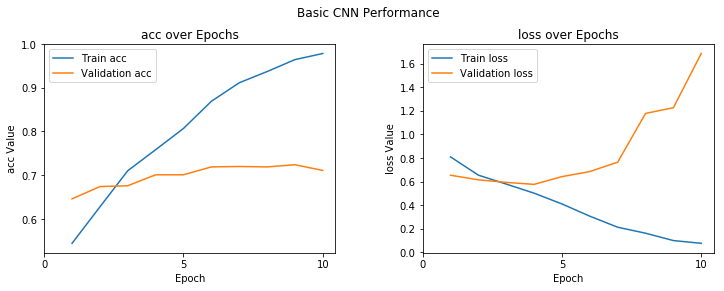

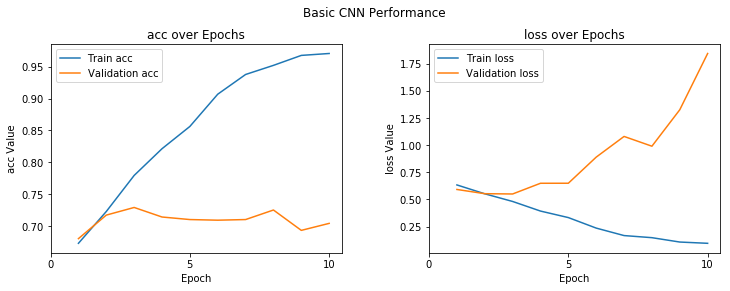

In [26]:

# plot a chart
def perf_plot(axis, epochs, seq_history, category):
    # now the first enumerates the epochs
    epoch_list = list(range(1, epochs+1))
    
    # Now for the first subplot show the accuracies
    axis.plot(epoch_list, seq_history.history[category], label='Train '+ category)
    axis.plot(epoch_list, seq_history.history['val_' + category], label='Validation '+  category)

    # now style the two 
    axis.set_xticks(np.arange(0, epochs + 1, 5))
    axis.set_ylabel(category + ' Value')
    axis.set_xlabel('Epoch')
    axis.set_title(category + ' over Epochs')
    legend = axis.legend(loc="best")
    return legend

# create two subplots
def plot_model(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    t = f.suptitle('Basic CNN Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)
    l1 = perf_plot(ax1, epochs, history, 'acc')
    l2 = perf_plot(ax2, epochs, history, 'loss')
    
plot_model(seq_history)
plot_model(func_history)


# CNN Adding regularization with dropouts
The above plots are the classic example of overfitting. The Training accuracy improves but the validation accurcy stays the same. And the losses for validation actually increase over time.

Using a dropout reduces overfitting on the training set. We will also try L2 regularization when this 
is verified to work.

In [ ]:
# Now create a model with dropouts after each

